# Model surface GHI using Sentinel-2, Sentinel-5P, Landsat, DSM and LUT 

Requirements: 

- A GOOGLE cloud project linked to your GOOGLE account


### My project 

Google account: gelieza.gk@gmail.com


cloud project ID: sample-project-452812 


cloud project name: Sample Project


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap
import math
import datetime
import calendar
import pytz
import pvlib

In [2]:
# Authorization and initialization of the GEE
# OBS: You must create our own project on Google
# Authenticate Earth Engine
ee.Authenticate()
#
# Initialize Earth Engine
my_project_name = 'sample-project-452812' # use here the name of your own project on Google
ee.Initialize(project=my_project_name)

In [3]:
# Convert degree to radian
def deg2rad(deg):
    return deg * math.pi / 180

# Define the center of the bounding box (Bergen, Norway)
CENTER_LAT = 60.39
CENTER_LON = 5.33

# Approximate degree adjustments for 100km x 100km box
DEG_LAT_TO_KM = 111.412  # 1 degree latitude at 60° converted to km (https://en.wikipedia.org/wiki/Latitude)
DEG_LON_TO_KM = 111.317 * math.cos(deg2rad(CENTER_LAT))  # 1 degree longitude converted to km
LAT_OFFSET = 12.5 / DEG_LAT_TO_KM  # ~10km north/south
LON_OFFSET = 12.5 / DEG_LON_TO_KM  # ~10km east/west (varies with latitude, approximation)

# Define the bounding box
BBOX = {
    "north": CENTER_LAT + LAT_OFFSET,
    "south": CENTER_LAT - LAT_OFFSET,
    "west": CENTER_LON - LON_OFFSET,
    "east": CENTER_LON + LON_OFFSET
}

print(BBOX)

# Geometry Rectangle of Form minLng, minLat, maxLng, maxLat
bergen_roi = ee.Geometry.Rectangle([BBOX["west"], BBOX["south"], BBOX["east"], BBOX["north"]])
south, north = -65.0, 65.0
west,  east  = -8.0, 128.0

# Rectangle geometry; geodesic=False keeps straight edges on the map
Meteosat_east = ee.Geometry.Rectangle([west, south, east, north], proj='EPSG:4326', geodesic=False)
Meteosat_disk = ee.Geometry.Rectangle([-65.0, south, 65.0, north], proj='EPSG:4326', geodesic=False)
Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10)

# Add the geometry to the map
Map.addLayer(bergen_roi, {"color": "red"}, "Bergen ROI")
Map.addLayer(Meteosat_east, {"color": "blue"}, "Meteosat east")
Map.addLayer(Meteosat_disk, {"color": "green"}, "Meteosat disk")

# Display the weather stations
stations = {
    #"Fana - Stend": (60.261870, 5.302989),
    "Flesland Bergen": (60.292792, 5.222689),
    "Florida": (60.3833, 5.3333)
}

for name, (lat, lon) in stations.items():
    point = ee.Geometry.Point([lon, lat])
    Map.addLayer(point, {"color": "blue"}, name)
    
# Add elevation map from Hoydedata National Elevation Project 1m
dsm = ee.Image("projects/sample-project-452812/assets/bergen_dsm_1m_zip").clip(bergen_roi)

elevation_vis = {
    'min': 0,
    'max': 800,
    'palette': ['blue', "green", 'brown', 'white']
}

Map.addLayer(dsm, elevation_vis, 'Elevation (DSM 1m)')

# Display the map
Map

{'north': 60.50219617276416, 'south': 60.27780382723584, 'west': 5.10273148294384, 'east': 5.55726851705616}


Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [4]:
# Export DSM to drive 

# Load DSM and clip to ROI
dsm = ee.Image("projects/sample-project-452812/assets/bergen_dsm_1m_zip").clip(bergen_roi)

# Reproject DSM to EPSG:4326
dsm_1m = dsm.reproject(crs="EPSG:4326", scale=1)

# Resample to 10m and reproject
dsm_10m = dsm.reproject(crs="EPSG:4326", scale=10)

# Export 1m DSM
task1 = ee.batch.Export.image.toDrive(
    image=dsm_1m,
    description="DSM_Bergen_1m_WGS84",
    folder="EarthEngineExports",
    fileNamePrefix="bergen_dsm_1m_epsg4326",
    scale=1,
    region=bergen_roi,
    crs="EPSG:4326",
    maxPixels=1e13
)

# Export 10m DSM
task2 = ee.batch.Export.image.toDrive(
    image=dsm_10m,
    description="DSM_Bergen_10m_WGS84",
    folder="EarthEngineExports",
    fileNamePrefix="bergen_dsm_10m_epsg4326",
    scale=10,
    region=bergen_roi,
    crs="EPSG:4326",
    maxPixels=1e13
)

# Start both tasks
task1.start()
task2.start()

print("Both exports started. Check the Earth Engine Tasks tab or your Google Drive when finished.")

Both exports started. Check the Earth Engine Tasks tab or your Google Drive when finished.


In [8]:
# Load all datasets
# Binary mask for cloud mask
CLD_PRB_THRESH = 50 # turn int data to binary using different thresholds

def add_cloud_mask(image):
    cloud_mask = image.select('probability').gt(CLD_PRB_THRESH).rename('cloud_mask')
    # drop band probability immediately for performance reasons
    return image.addBands(cloud_mask).select(['cloud_mask'])

# Convert cloud base height from m to km (it is stored in km in the LUT)
def convert_cbh_to_km(image):
    cbh_km = image.select('cloud_base_height').divide(1000).rename('cloud_base_height')
    return image.addBands(cbh_km, overwrite=True)

def print_collection_info(collection, name=""):
    """Prints the number of images and unique acquisition dates in a collection."""
    total_size = collection.size().getInfo()
    unique_dates = collection.aggregate_array('system:time_start') \
        .map(lambda t: ee.Date(t).format('YYYY-MM-dd')) \
        .distinct().size().getInfo()
    
    print(f"📦 {name} - Total images: {total_size}, Unique acquisition dates: {unique_dates}")
    return total_size, unique_dates

# Count how many pixels are actually in bergen_roi
def has_valid_pixels(img):
    # Reduce over ROI, count non-masked pixels
    count = img.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=bergen_roi,
        scale=img.projection().nominalScale(),
        maxPixels=1e9
    ).values().get(0)  # get the first band's count

    # Set property to image
    return img.set('validPixelCount', count)

def add_date(img):
    # Add YYYY-MM-dd as property
    return img.set('date', img.date().format('YYYY-MM-dd'))

startDate = "2017-10-01" #"2018-07-12" # first date in S5P with bergen overlap
endDate = "2017-12-01" #"2025-07-13" # end date in S5P

# Sentinel-5P cloud properties
s5p = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CLOUD").filterDate(startDate, endDate).filterBounds(bergen_roi) \
    .select(["cloud_optical_depth", "surface_albedo", "cloud_base_height"]) \
    .map(convert_cbh_to_km) \
    .map(has_valid_pixels) \
    .filter(ee.Filter.gt('validPixelCount', 0)) \
    .map(add_date)

# Sentinel-2 cloud probability 
s2_cloud = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY") \
        .filterDate(startDate, endDate) \
        .filterBounds(bergen_roi) \
        .map(add_cloud_mask) \
        .map(has_valid_pixels) \
        .filter(ee.Filter.gt('validPixelCount', 0)) \
        .map(add_date)

    
# Sentinel-2 Harmonized top of atmosphere
def extract_s2harm_cloud_bits(image):
    qa60 = image.select("QA60")
    
    # Extract Bit 11 (cirrus clouds)
    cirrus = qa60.bitwiseAnd(1 << 11).rightShift(11).rename("is_cirrus")

    # Only select 'is_cirrus' for performance reasons - is roughly identical to the negative of 'is_opaque'
    return image.addBands([cirrus]).select(["is_cirrus"])

# Filter and process Sentinel-2 Harmonized
s2_harm = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .select("QA60") \
    .map(extract_s2harm_cloud_bits) \
    .map(has_valid_pixels) \
    .filter(ee.Filter.gt('validPixelCount', 0)) \
    .map(add_date)

# Combine multiple images into one per day (to cover whole Bergen area in one image)
def daily_mosaic(ic):
    # Get unique dates
    dates = ic.aggregate_array('date').distinct()
    
    def make_mosaic(d):
        d = ee.String(d)
        daily_ic = ic.filter(ee.Filter.eq('date', d))
        
        # Get list of acquisition times
        times = daily_ic.aggregate_array('system:time_start')
        min_time = ee.Number(times.reduce(ee.Reducer.min()))
        max_time = ee.Number(times.reduce(ee.Reducer.max()))
        time_range = max_time.subtract(min_time)
        
        mosaic = daily_ic.mosaic()
        
        return (mosaic
                .set('date', d)
                .set('system:time_start', min_time)          # earliest time
                .set('start_time_range', time_range)) # span of times
    
    return ee.ImageCollection(dates.map(make_mosaic))


In [10]:
# Get viewing angles for a sample image in s2_harm
img = s2_harm.filterDate("2017-11-25", "2017-12-01").first()

# Build list of properties (all azimuth + zenith keys)
bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']
azimuth_keys = [f'MEAN_INCIDENCE_AZIMUTH_ANGLE_{b}' for b in bands]
zenith_keys  = [f'MEAN_INCIDENCE_ZENITH_ANGLE_{b}' for b in bands]

all_keys = azimuth_keys + zenith_keys

# Fetch property values
props = img.toDictionary(all_keys).getInfo()

# Print results
print("Viewing angles for image:", img.get("system:index").getInfo())
for k in all_keys:
    print(f"{k}: {props.get(k)}")

Viewing angles for image: 20171125T110401_20171125T110358_T32VKM
MEAN_INCIDENCE_AZIMUTH_ANGLE_B1: 108.495415583
MEAN_INCIDENCE_AZIMUTH_ANGLE_B2: 107.931795414
MEAN_INCIDENCE_AZIMUTH_ANGLE_B3: 108.062098243
MEAN_INCIDENCE_AZIMUTH_ANGLE_B4: 108.183919434
MEAN_INCIDENCE_AZIMUTH_ANGLE_B5: 108.248005691
MEAN_INCIDENCE_AZIMUTH_ANGLE_B6: 108.290269697
MEAN_INCIDENCE_AZIMUTH_ANGLE_B7: 108.341158525
MEAN_INCIDENCE_AZIMUTH_ANGLE_B8: 107.998453128
MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A: 108.401039406
MEAN_INCIDENCE_AZIMUTH_ANGLE_B9: 108.49251229
MEAN_INCIDENCE_AZIMUTH_ANGLE_B10: 108.197410416
MEAN_INCIDENCE_AZIMUTH_ANGLE_B11: 108.326768399
MEAN_INCIDENCE_AZIMUTH_ANGLE_B12: 108.405058025
MEAN_INCIDENCE_ZENITH_ANGLE_B1: 7.57375506496
MEAN_INCIDENCE_ZENITH_ANGLE_B2: 7.33533677866
MEAN_INCIDENCE_ZENITH_ANGLE_B3: 7.36561260209
MEAN_INCIDENCE_ZENITH_ANGLE_B4: 7.41982550191
MEAN_INCIDENCE_ZENITH_ANGLE_B5: 7.44499881944
MEAN_INCIDENCE_ZENITH_ANGLE_B6: 7.47307141177
MEAN_INCIDENCE_ZENITH_ANGLE_B7: 7.50399044715

In [18]:
# Test collection sizes 
s2_cloud_daily  = daily_mosaic(s2_cloud)

#print('Daily S2 count:', s2_cloud_daily.size().getInfo(), " vs. s2 count: ", s2_cloud.size().getInfo())

Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=9)
#TODO: test for different day, test for the same day of s5p and s2/s2harm, then continue with rest of code. 
# TODO: Check how many observations are left after combining all days into one image

# Take first S2 daily mosaic
sample_s2 = ee.Image(s2_cloud_daily.filterDate('2015-08-15', '2015-09-12').first())
display(sample_s2)

# Visualize cloud probability
vis = {'min': 0, 'max': 1, 'palette': ['blue', 'white']}
Map.addLayer(sample_s2.select('cloud_mask'), vis, 'cloud mask')

Map

Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [5]:
# Export pipeline s2
# Parameters
CLD_PRB_THRESH = 50
start_date_total = ee.Date("2022-02-08")
end_date_total = ee.Date("2025-08-31")
batch_months = 3  # 3-month batches
drive_folder = "S2_cloud_daily_mosaics"

# -----------------------------
# Helper functions
# -----------------------------
def add_cloud_mask(image):
    cloud_mask = image.select('probability').gt(CLD_PRB_THRESH).rename('cloud_mask')
    return image.addBands(cloud_mask).select(['cloud_mask'])

def has_valid_pixels(img):
    count = img.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=bergen_roi,
        scale=img.projection().nominalScale(),
        maxPixels=1e9
    ).values().get(0)
    return img.set('validPixelCount', count)

def add_date(img):
    return img.set('date', img.date().format('YYYY-MM-dd'))

def daily_mosaic(ic):
    dates = ic.aggregate_array('date').distinct()
    
    def make_mosaic(d):
        d = ee.String(d)
        daily_ic = ic.filter(ee.Filter.eq('date', d))
        times = daily_ic.aggregate_array('system:time_start')
        min_time = ee.Number(times.reduce(ee.Reducer.min()))
        max_time = ee.Number(times.reduce(ee.Reducer.max()))
        time_range = max_time.subtract(min_time)
        mosaic = daily_ic.mosaic()
        return (mosaic
                .set('date', d)
                .set('system:time_start', min_time)
                .set('start_time_range', time_range))
    
    return ee.ImageCollection(dates.map(make_mosaic))

def export_image(image, description):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=drive_folder,
        fileNamePrefix=description,
        region=bergen_roi,
        scale=10,
        maxPixels=1e13
    )
    task.start()

# -----------------------------
# Automated batch processing
# -----------------------------
current_start = start_date_total

while current_start.millis().getInfo() < end_date_total.millis().getInfo():
    # Define batch end date
    current_end = current_start.advance(batch_months, 'month')
    if current_end.millis().getInfo() > end_date_total.millis().getInfo():
        current_end = end_date_total

    print(f"Processing batch: {current_start.format('YYYY-MM-dd').getInfo()} to {current_end.format('YYYY-MM-dd').getInfo()}")

    # Load Sentinel-2 cloud probability and preprocess
    s2_cloud = (ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY")
                .filterDate(current_start, current_end)
                .filterBounds(bergen_roi)
                .map(add_cloud_mask)
                .map(has_valid_pixels)
                .filter(ee.Filter.gt('validPixelCount', 0))
                .map(add_date))

    # Daily mosaics
    s2_cloud_daily = daily_mosaic(s2_cloud)

    # Export each daily mosaic in this batch
    image_list = s2_cloud_daily.toList(s2_cloud_daily.size())
    n = image_list.size().getInfo()
    print(f"Number of images in batch: {n}")

    for i in range(n):
        img = ee.Image(image_list.get(i))
        start_millis = ee.Number(img.get('system:time_start'))
        time_range = ee.Number(img.get('start_time_range'))
        end_date = ee.Date(start_millis.add(time_range))
        description = ee.String('S2_cloud_') \
                        .cat(ee.Date(start_millis).format('YYYY-MM-dd_HH-mm-ss')) \
                        .cat('-') \
                        .cat(end_date.format('YYYY-MM-dd_HH-mm-ss')) \
                        .getInfo()
        export_image(img, description)
        print(f"Exporting {description}...")

    # Move to next batch
    current_start = current_end


Processing batch: 2022-02-08 to 2022-05-08
Number of images in batch: 35
Exporting S2_cloud_2022-02-10_11-11-09-2022-02-10_11-11-09...
Exporting S2_cloud_2022-02-12_11-01-51-2022-02-12_11-01-51...
Exporting S2_cloud_2022-02-15_11-11-41-2022-02-15_11-11-41...
Exporting S2_cloud_2022-02-17_11-00-09-2022-02-17_11-00-09...
Exporting S2_cloud_2022-02-20_11-09-59-2022-02-20_11-09-59...
Exporting S2_cloud_2022-02-22_11-00-51-2022-02-22_11-00-51...
Exporting S2_cloud_2022-02-25_11-10-51-2022-02-25_11-10-51...
Exporting S2_cloud_2022-02-27_10-58-59-2022-02-27_10-58-59...
Exporting S2_cloud_2022-03-02_11-08-59-2022-03-02_11-08-59...
Exporting S2_cloud_2022-03-04_10-59-41-2022-03-04_10-59-41...
Exporting S2_cloud_2022-03-07_11-09-21-2022-03-07_11-09-21...
Exporting S2_cloud_2022-03-09_10-57-59-2022-03-09_10-57-59...
Exporting S2_cloud_2022-03-12_11-07-49-2022-03-12_11-07-49...
Exporting S2_cloud_2022-03-14_10-58-31-2022-03-14_10-58-31...
Exporting S2_cloud_2022-03-17_11-08-11-2022-03-17_11-08-11.

In [ ]:

def extract_landsat_cloud_bits(image):
    """
    Extracts cloud_mask and is_cirrus bands from the QA_PIXEL band in Landsat Collection.
    - cloud_mask = 1 if Bit 3 is set (cloud) AND Bit 6 is NOT set (not clear)
    - is_cirrus = Bit 2
    The original QA_PIXEL band is removed.
    """
    qa = image.select("QA_PIXEL")

    # Extract bits
    bit2 = qa.bitwiseAnd(1 << 2).rightShift(2)  # Cirrus
    bit3 = qa.bitwiseAnd(1 << 3).rightShift(3)  # Cloud
    bit6 = qa.bitwiseAnd(1 << 6).rightShift(6)  # Clear

    # cloud_mask = 1 if cloud (bit3==1) AND NOT clear (bit6==0)
    cloud_mask = bit3.And(bit6.Not())

    # Rename and add bands
    return image \
        .addBands(cloud_mask.rename("cloud_mask")) \
        .addBands(bit2.rename("is_cirrus")) \
        .select(["cloud_mask", "is_cirrus"])  # drop QA_PIXEL

# Landsat
l9_T1 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .select('QA_PIXEL') \
    .map(extract_landsat_cloud_bits)
l9_T2 = ee.ImageCollection("LANDSAT/LC09/C02/T2_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .select('QA_PIXEL') \
    .map(extract_landsat_cloud_bits)
l8_T1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .select('QA_PIXEL') \
    .map(extract_landsat_cloud_bits)
l8_T2 = ee.ImageCollection("LANDSAT/LC08/C02/T2_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .select('QA_PIXEL') \
    .map(extract_landsat_cloud_bits)
   
l8_9 = l8_T1 \
    .merge(l8_T2) \
    .merge(l9_T1) \
    .merge(l9_T2) \
    .map(has_valid_pixels) \
    .filter(ee.Filter.gt('validPixelCount', 0)) # from 8 to 8

In [5]:
# Filter only Sentinel-2 images that have an S5P match (s2 match is guaranteed within 10 min)
def count_s5p_matches(img):
    """Annotate where image has a matching observation with s5p (+- 15 min acquisition time)"""
    start = ee.Date(img.get('system:time_start'))
    start = start.advance(-30, 'minute')
    end   = start.advance(30, 'minute')

    # Match Sentinel-5P
    s5p_matches = s5p.filterDate(start, end).filterBounds(img.geometry())
    s5p_size = s5p_matches.size()
    return img.set({'s5p_match_size': s5p_size})

def count_s2h_matches(img):
    """Annotate where image has a matching observation with s2 harm (+- 15 min acquisition time)"""
    start = ee.Date(img.get('system:time_start'))
    start = start.advance(-15, 'minute')
    end   = start.advance(15, 'minute')

    # Match Sentinel-5P
    s2h_matches = s2_harm.filterDate(start, end).filterBounds(img.geometry())
    s2h_size = s2h_matches.size()
    return img.set({'s2h_match_size': s2h_size})

# Annotate Sentinel-2 with S5P and S2H matches
def annotate_s5p_matches(img):
    start = ee.Date(img.get('system:time_start'))
    start = start.advance(-30, 'minute')
    end   = start.advance(30, 'minute')

    # --- Sentinel-5P (guaranteed to exist after filtering) ---
    s5p_matches = s5p.filterDate(start, end).filterBounds(img.geometry())
    s5p_img = s5p_matches.mean()

    # --- Reduce to scalars ---
    albedo_mean = s5p_img.select('surface_albedo').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bergen_roi,
        scale=1113,
        bestEffort=True
    ).get('surface_albedo')

    cod_mean = s5p_img.select('cloud_optical_depth').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bergen_roi,
        scale=1113,
        bestEffort=True
    ).get('cloud_optical_depth')

    cbh_mean = s5p_img.select('cloud_base_height').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bergen_roi,
        scale=1113,
        bestEffort=True
    ).get('cloud_base_height')

    return img.set({
        'mean_albedo': albedo_mean,
        'mean_cod': cod_mean,
        'mean_cbh': cbh_mean,
        'cloud_type': 0, # set default first
        'month': start.get('month'),
        'doy': start.getRelative('day', 'year').add(1),
        'hour': start.get('hour'),
        'minute': start.get('minute')
    })
    
def annotate_s2h_matches(s2_img):
    """Filter for cloud type data in corresponding s2 images (+-15 min of acquisition time) and 
    as image property."""
    
    start = ee.Date(s2_img.get('system:time_start'))
    s2_start = start.advance(-15, 'minute')
    s2_end   = start.advance(15, 'minute')
    
    # --- Sentinel-2 Harmonized ---
    s2h_matches = s2_harm.filterDate(s2_start, s2_end).filterBounds(s2_img.geometry())
    s2h_img = s2h_matches.mode()
    
    cirrus_mode = s2h_img.select('is_cirrus').reduceRegion(
        reducer=ee.Reducer.mode(),
        geometry=bergen_roi,
        scale=60,
        bestEffort=True
    ).get('is_cirrus')
    
    return s2_img.set({'cloud_type': cirrus_mode})

def annotate_ls_cloud_type(ls_img): 
    """Set the mode cloud type (ice/water) as an image property. """
    cirrus_mode = ls_img.select('is_cirrus').reduceRegion(
        reducer=ee.Reducer.mode(),
        geometry=bergen_roi,
        scale=30,
        bestEffort=True
    ).get('is_cirrus')
    
    return ls_img.set({'cloud_type': cirrus_mode}).select(["cloud_mask"]) #drop is-cirrus band
    
# Filter only landsat images with s5p matches
ls_with_s5p_match = l8_9.map(count_s5p_matches).filter(ee.Filter.gt('s5p_match_size', 0))
ls_annotated = ls_with_s5p_match.map(annotate_s5p_matches).map(annotate_ls_cloud_type)

# Filter only those s2 images with S5P matches
s2_with_s5p_match = s2_cloud.map(count_s5p_matches).filter(ee.Filter.gt('s5p_match_size', 0))

# Now annotate with cloud properties from s5p (set default value for cloud_type = 0)
with_s5p_match_annotated = s2_with_s5p_match.map(annotate_s5p_matches).map(count_s2h_matches)

# Now overwrite default values with values from Sentinel Harmonized
with_s2h_match = with_s5p_match_annotated.filter(ee.Filter.gt('s2h_match_size', 0))
with_s2h_cloud_type = with_s2h_match.map(annotate_s2h_matches)

# Now overwrite default values with "ice" if cod < 20 and cbh > 5 (constructed for images which do not have
# a match in s2h)
without_s2h_match = with_s5p_match_annotated.filter(ee.Filter.eq('s2h_match_size',0))
# TODO: manually set to ice cloud later when everything else works - merge 3 disjunctive subsets 
""" cloud_type1 = without_s2h_match \
    .filter(ee.Filter.lt('mean_cod', 20)) \
    .filter(ee.Filter.gt('mean_cbh', 5)) \
    .map(lambda img: img.set({'cloud_type': 1}))
print("cloud_type1 size: ", cloud_type1.size().getInfo()) """

# Merge all together, remove duplicates
with_cloud_props = without_s2h_match.merge(with_s2h_cloud_type)#.merge(ls_annotated)
#print("s2_with_cloud_props size: ", s2_with_cloud_props.size().getInfo())
#display(s2_with_cloud_props)

# Final cleaning: ensure no nulls from reducers
# TODO: possibly fill up with default values instead of deleting them 
with_cloud_props = with_cloud_props.filter(ee.Filter.notNull(['mean_albedo', 'mean_cod', 'mean_cbh', 'cloud_type']))

In [6]:
def add_closest_hour(img):
    hour = ee.Number(img.get('hour'))
    minute = ee.Number(img.get('minute'))
    closest_hour = hour.add(minute.divide(60)).round()
    return img.set('closest_hour', closest_hour)

with_cloud_props = with_cloud_props.map(add_closest_hour)

# Get min and max closest hour
min_hour = with_cloud_props.aggregate_min('closest_hour')
max_hour = with_cloud_props.aggregate_max('closest_hour')

In [ ]:
# Just for debugging
img_id = "20200425T104619_20200425T104615_T32VLM"
img = s2_cloud.filter(ee.Filter.eq("system:index", img_id)).first()

# Time window
start = ee.Date(img.get('system:time_start'))
start = start.advance(-15, 'minute')
end   = start.advance(15, 'minute')

# --- Match Sentinel-5P ---
s5p_matches = s5p.filterDate(start, end).filterBounds(img.geometry())

# If no matches, return null (will be filtered later)
s5p_size = s5p_matches.size()
print("S5p match size: ", s5p_size.getInfo())
s5p_img = s5p_matches.mean()

# --- Match Sentinel-2 Harmonized ---
s2h_matches = s2_harm.filterDate(
    start.advance(-10, 'minute'), # 10 minutes because the acquisition time is the same (same satellite)
    start.advance(10, 'minute')   # but practically there is a max diff of 10 min (due to processing?)
).filterBounds(img.geometry()) #TODO: might be faster with bergen_roi (simpler geometry?)

s2h_size = s2h_matches.size()
print("S2 match size: ", s2h_size.getInfo())
s2h_img = s2h_matches.mode()

# Cast back to ee.Image inside the conditional
s5p_img = ee.Image(s5p_img)
s2h_img = ee.Image(s2h_img)

# --- Reduce to scalars (properties) ---
albedo_mean = s5p_img.select('surface_albedo').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=bergen_roi,
    scale=1113,
    bestEffort=True
).get('surface_albedo')

cod_mean = s5p_img.select('cloud_optical_depth').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=bergen_roi,
    scale=1113,
    bestEffort=True
).get('cloud_optical_depth')

cbh_mean = s5p_img.select('cloud_base_height').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=bergen_roi,
    scale=1113,
    bestEffort=True
).get('cloud_base_height')

cirrus_mode = s2h_img.select('is_cirrus').reduceRegion(
    reducer=ee.Reducer.mode(),
    geometry=bergen_roi,
    scale=1113,
    bestEffort=True
).get('is_cirrus')

# Attach properties to original S2 cloud mask image
img.set({
    'mean_albedo': albedo_mean,
    'mean_cod': cod_mean,
    'mean_cbh': cbh_mean,
    'cloud_type': cirrus_mode,
    'month': start.get('month'),
    'doy': start.getRelative('day', 'year').add(1),
    'hour': start.get('hour'),
    'minute': start.get('minute')
})

#print("mean_albedo:", s2_img.get("mean_albedo").getInfo())
#print("mean_cod:",    s2_img.get("mean_cod").getInfo())
print("mean_cbh:",    img.get("mean_cbh").getInfo())

S5p match size:  1
S2 match size:  0


mean_cbh: None


In [ ]:
""" # Filter for null values and set to default values so LUT will not return null
missing_albedo = annotated.filter(ee.Filter.notNull(['mean_albedo']).Not()).map(lambda img: img.set({'mean_albedo': 0.2}))
annotated = annotated.filter(ee.Filter.notNull(['mean_albedo'])).merge(missing_albedo)

missing_cod = annotated.filter(ee.Filter.notNull(['mean_cod']).Not()).map(lambda img: img.set({'mean_cod': 15.0}))
annotated = annotated.filter(ee.Filter.notNull(['mean_cod'])).merge(missing_cod)

missing_cbh = annotated.filter(ee.Filter.notNull(['mean_cbh']).Not()).map(lambda img: img.set({'mean_cbh': 1.0}))
annotated = annotated.filter(ee.Filter.notNull(['mean_cbh'])).merge(missing_cbh)

missing_cloud_type = annotated.filter(ee.Filter.notNull(['cloud_type']).Not()).map(lambda img: img.set({'cloud_type': 0}))
annotated = annotated.filter(ee.Filter.notNull(['cloud_type'])).merge(missing_cloud_type)

# Set cloud type to 0 = "water" if cod > 30
high_cod = annotated.filter(ee.Filter.gt('mean_cod', 30)).map(lambda img: img.set({'cloud_type': 0}))
annotated = annotated.filter(ee.Filter.lte('mean_cod', 30)).merge(high_cod) # Test successful: same number of images """

In [7]:
# Import local LUT and convert to dict 
# Load the CSV
lut_path = "../output/LUT/LUT.csv"
lut_df = pd.read_csv(lut_path)

# Preprocess and reduce LUT
# Filter hours (replace min_hour and max_hour with actual values)
min_hour, max_hour = 11, 11
lut_df = lut_df[(lut_df['Hour'] >= min_hour) & (lut_df['Hour'] <= max_hour)]

# Add numeric cloud type
lut_df['cloud_type_num'] = np.where(lut_df['CloudType'] == 'ice', 1, 0)

# Keep only relevant columns
lut_df = lut_df[['Hour', 'DOY', 'cloud_type_num', 'Albedo', 'CloudBase_km', 'Tau550',
                 'Direct_clear', 'Diffuse_clear', 'Direct_cloudy', 'Diffuse_cloudy']]
def make_key(row):
    return f"{int(row['Hour'])}_{int(row['DOY'])}_{int(row['cloud_type_num'])}_{row['Albedo']:.3f}_{row['Tau550']:.2f}_{row['CloudBase_km']:.3f}"

lut_dict = {}
for idx, row in lut_df.iterrows():
    key = make_key(row)
    lut_dict[key] = {
        'Direct_clear': row['Direct_clear'],
        'Diffuse_clear': row['Diffuse_clear'],
        'Direct_cloudy': row['Direct_cloudy'],
        'Diffuse_cloudy': row['Diffuse_cloudy']
    }

# Convert Python dict to ee.Dictionary
lut_ee = ee.Dictionary(lut_dict)

In [8]:
# Parameter lists
DOY_VALUES = ee.List([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349])
ALBEDO_VALUES = ee.List([0.081, 0.129, 0.174, 0.224, 0.354])
COD_VALUES = ee.List([1.0, 3.41, 5.50, 7.68, 10.18, 13.67, 19.34, 27.79,
                                   42.03, 73.23, 125.42, 250.0])
CBH_VALUES = ee.List([0.08, 0.167, 0.285, 0.571, 0.915, 1.286, 1.753,
                                   2.370, 3.171, 4.165, 5.451, 6.543, 8.498])

# Define Fallback feature with default values to flag images where no LUT match was found
fallback_dict = ee.Dictionary({
        'Diffuse_clear': -1,
        'Diffuse_cloudy': -1,
        'Direct_clear': -1,
        'Direct_cloudy': -1,
        'DOY': -999,
        'Hour': -1,
        'Albedo': -1,
        'Tau550': -1,
        'CloudBase_km': -1,
        'cloud_type_num': -1
    })

# Retrieve GHI data from lut dictionary
# Example keys: "DOY_Hour_Albedo_Cod_CBH_Phase"

def bin_value_ee(x, bins):
    """Server-side snap to nearest bin."""
    diffs = bins.map(lambda b: ee.Number(x).subtract(b).abs())
    min_idx = diffs.indexOf(diffs.reduce(ee.Reducer.min()))
    return bins.get(min_idx)

def match_to_lut_dict(image):
    doy = ee.Number(image.get('doy'))
    closest_hour = ee.Number(image.get('closest_hour'))
    albedo = ee.Number(image.get('mean_albedo'))
    cod = ee.Number(image.get('mean_cod'))
    cbh = ee.Number(image.get('mean_cbh'))
    phase = ee.Number(image.get('cloud_type'))  # 1=ice, 0=water

    # Snap to bins
    closest_doy = ee.Number(bin_value_ee(doy, DOY_VALUES))
    closest_albedo = ee.Number(bin_value_ee(albedo, ALBEDO_VALUES))
    closest_cod = ee.Number(bin_value_ee(cod, COD_VALUES))
    closest_cbh = ee.Number(bin_value_ee(cbh, CBH_VALUES))

    # Construct key string
    key = ee.String(closest_hour.int()).cat('_') \
      .cat(ee.String(closest_doy.int())).cat('_') \
      .cat(ee.String(phase.int())).cat('_') \
      .cat(closest_albedo.format('%.3f')).cat('_') \
      .cat(closest_cod.format('%.2f')).cat('_') \
      .cat(closest_cbh.format('%.3f'))

    # Lookup ee.Dictionary
    values = lut_ee.get(key, fallback_dict)

    # Set LUT values as image properties
    return image.set(values)

# Apply to ImageCollection
with_lut = with_cloud_props.map(match_to_lut_dict)
# Filter out masked images with Diffuse_clear = -1 --> no match found in LUT 
with_lut = with_lut.filter(ee.Filter.gte('Diffuse_clear', 0)) 

In [ ]:
# Convert to Mercator projection for hillShade computation
dsm_merc = ee.Image("projects/sample-project-452812/assets/bergen_dsm_merc_10m") 

# Loop over merged collection and add band hillshade to each image from zenith angle 
# source: NOAA Global Monitoring Division: General Solar Position Calculations (https://gml.noaa.gov/grad/solcalc/solareqns.PDF)
def add_hillshadow_band(image):
    date = ee.Date(image.get('system:time_start'))

    # Extract UTC hour and day of year
    doy = date.getRelative('day', 'year').add(1)  # DOY = 1-based
    hour = date.get('hour')
    minute = date.get('minute')
    second = date.get('second')
    
    # Note: treat leap years as non-leap years for simplicity (avoid Algorithms.If())
    # Fractional year γ (in radians)
    gamma = ee.Number(2 * math.pi).divide(365).multiply(
        doy.subtract(1).add(hour.subtract(12).divide(24))
    )

    # Equation of time (in minutes)
    eqtime = ee.Number(229.18).multiply(
        ee.Number(0.000075)
        .add(ee.Number(0.001868).multiply(gamma.cos()))
        .subtract(ee.Number(0.032077).multiply(gamma.sin()))
        .subtract(ee.Number(0.014615).multiply((gamma.multiply(2)).cos()))
        .subtract(ee.Number(0.040849).multiply((gamma.multiply(2)).sin()))
    )

    # Solar declination (in radians)
    decl = (
        ee.Number(0.006918)
        .subtract(ee.Number(0.399912).multiply(gamma.cos()))
        .add(ee.Number(0.070257).multiply(gamma.sin()))
        .subtract(ee.Number(0.006758).multiply((gamma.multiply(2)).cos()))
        .add(ee.Number(0.000907).multiply((gamma.multiply(2)).sin()))
        .subtract(ee.Number(0.002697).multiply((gamma.multiply(3)).cos()))
        .add(ee.Number(0.00148).multiply((gamma.multiply(3)).sin()))
    )


    # Time offset in minutes
    time_offset = eqtime.add(ee.Number(CENTER_LON).multiply(4)) 
    # Note: no time-zone awareness because system:time_start is in UTC

    # True solar time (TST), in minutes
    tst = hour.multiply(60).add(minute).add(second.divide(60)).add(time_offset)

    # Hour angle (degrees)
    ha = tst.divide(4).subtract(180)

    # Convert to radians
    lat_rad = ee.Number(CENTER_LAT).multiply(math.pi / 180)
    ha_rad = ha.multiply(math.pi / 180)

    # Solar zenith angle (degrees)
    cos_zenith = lat_rad.sin().multiply(decl.sin()).add(
        lat_rad.cos().multiply(decl.cos()).multiply(ha_rad.cos())
    )
    
    zenith_rad = cos_zenith.acos()
    zenith_deg = zenith_rad.multiply(180 / math.pi)

    # Solar azimuth angle (degrees)
    cos_azimuth = (
        lat_rad.sin().multiply(cos_zenith).subtract(decl.sin())
    ).divide(
        lat_rad.cos().multiply(zenith_rad.sin())
    )
    
    azimuth_deg = ee.Number(180).subtract(cos_azimuth.acos().multiply(180 / math.pi))

    # Hillshadow computation (terrain shadow mask)
    shadow = ee.Terrain.hillShadow(
        dsm_merc,
        azimuth_deg,
        zenith_deg
    ).rename('hillshadow')

    return image.addBands(shadow)

shadowed_collection = with_lut.map(add_hillshadow_band) 

In [19]:
test_img = ee.Image(shadowed_collection.first())
# Create interactive map centered on Bergen
Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10, width=800, height=400)

# Visualize hillshadow band: 
hillshadow_vis = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'ffffff']  # white = sunlit, black = shadow
}

Map.addLayer(test_img.select('hillshadow'), hillshadow_vis, 'Hillshadow')
Map.addLayer(test_img.select('cloud_mask'), hillshadow_vis, 'Original Image')  # Optional: add base image

Map.addLayerControl()
Map

Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [10]:
# Compute GHI from cloud and hillshadow logic
def compute_ghi(image):
    # Constants from LUT
    dir_clear = ee.Number(image.get('Direct_clear'))
    dif_clear = ee.Number(image.get('Diffuse_clear'))
    dir_cloudy = ee.Number(image.get('Direct_cloudy'))
    dif_cloudy = ee.Number(image.get('Diffuse_cloudy'))

    cloud_mask = image.select('cloud_mask')  # 1 = cloudy
    hillshadow = image.select('hillshadow')  # 1 = in sunlight

    ghi_direct = cloud_mask.eq(1).multiply(dir_cloudy).add(
                   cloud_mask.eq(0).multiply(dir_clear))

    ghi_diffuse = cloud_mask.eq(1).multiply(dif_cloudy).add(
                    cloud_mask.eq(0).multiply(dif_clear))

    ghi_total = hillshadow.eq(0).multiply(ghi_diffuse).add(
                  hillshadow.eq(1).multiply(ghi_direct.add(ghi_diffuse))) # 1=sunlight

    # Ensure consistent float type and band names
    ghi_total = ghi_total.toFloat().rename('GHI_total')

    # For memory optimization, only add ghi_total and remove all other bands 
    return image.addBands([ghi_total], overwrite=True).select('GHI_total')
    

with_ghi = shadowed_collection.map(compute_ghi)

In [66]:
test_img = shadowed_collection.filter(ee.Filter.eq('system:index', '1_20200714T104619_20200714T105055_T32VLN')).first() 
test_img_with_ghi = compute_ghi(ee.Image(test_img))

# Visualize 
# Create interactive map centered on Bergen
Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10,height=400, width=800)

# Visualize ghi band: blue = no sunlight, yellow = a lot of sunlight
ghi_vis = {
    'min': 0,
    'max': 1000,
    'palette': ['blue', 'green', 'yellow']  # white = sunlit, black = shadow
}

hillshadow_vis = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'ffffff']  # white = sunlit, black = shadow
}

Map.addLayer(test_img.select('hillshadow'), hillshadow_vis, 'Hillshadow')
Map.addLayer(test_img_with_ghi.select('GHI_total'), ghi_vis, 'GHI Total')  
Map.addLayer(test_img.select('cloud_mask'), hillshadow_vis, 'Original Image') 

Map.addLayerControl()
Map

Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

Aggregate and export months, seasons and alltime aggregate
Image count per month: (merged_all)
Month 1: 324 images
Month 2: 360 images
Month 3: 438 images
Month 4: 542 images
Month 5: 507 images
Month 6: 509 images
Month 7: 448 images
Month 8: 480 images
Month 9: 383 images
Month 10: 430 images
Month 11: 387 images
Month 12: 124 images

In [11]:
scale = 10

def export_img(image, filename_prefix):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=filename_prefix,
        folder='GEE_exports',
        fileNamePrefix=filename_prefix,
        region=bergen_roi,
        scale=scale,
        maxPixels=1e13
    )
    task.start()
    print(f"Export task for image '{filename_prefix}' has been scheduled.")


# Seasonal aggregates 
SEASONS = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}    

# Export alltime 
ghi_alltime = with_ghi.select('GHI_total').mean()
export_img(ghi_alltime, f"surface_ghi_mean_scale_{scale}_s2_tol_30") 

# Export seasonal mean images
for season in SEASONS:
    months = ee.List(SEASONS[season])
    with_s2_s5p_match = with_ghi.filter(ee.Filter.inList('month', months))
    mean_img = with_s2_s5p_match.select('GHI_total').mean()
    filename = f"surface_ghi_mean_{season}_scale_{scale}_s2_tol_30"
    export_img(mean_img, filename)

# Export monthly mean images
for m in range(1, 13):
    filtered_month = with_ghi.filter(ee.Filter.eq('month', m))
    mean_img = filtered_month.select('GHI_total').mean()
    month_name = calendar.month_name[m]  # e.g., January, February, ...
    filename = f"surface_ghi_mean_{month_name}_scale_{scale}_s2_tol_30"
    export_img(mean_img, filename)

Export task for image 'surface_ghi_mean_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_Winter_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_Spring_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_Summer_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_Autumn_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_January_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_February_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_March_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_April_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_May_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_June_scale_10_s2_tol_30' has been scheduled.
Export task for image 'surface_ghi_mean_July_scale_10_

Total unique acquisition dates: 358


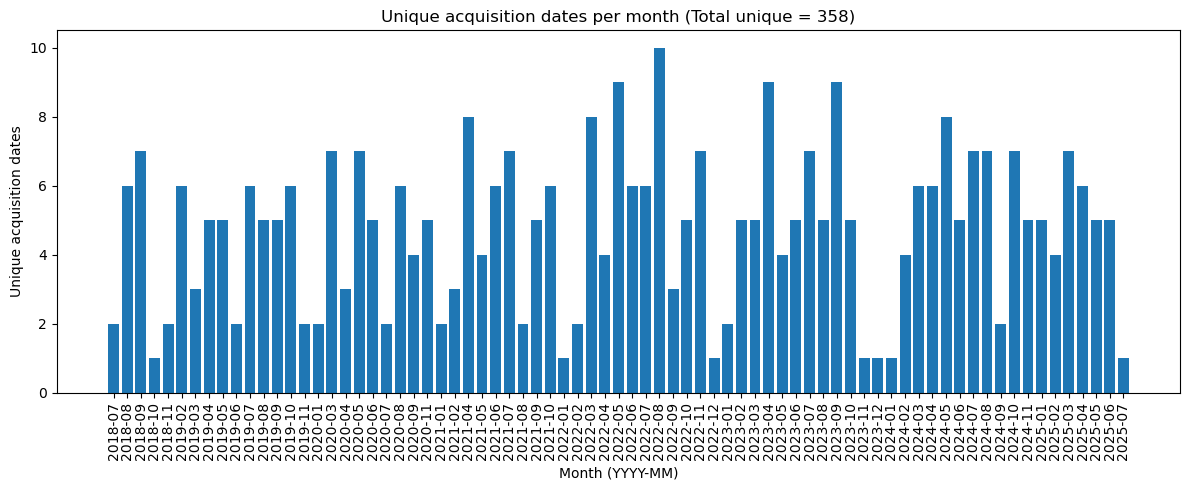

In [77]:
# --- Step 1: add acquisition date + month ---
def add_date_props(img):
    date = ee.Date(img.get('system:time_start'))
    return img.set({
        'acq_date': date.format('YYYY-MM-dd'),
        'month': date.format('YYYY-MM')
    })

with_cloud_props = with_cloud_props.map(add_date_props)

# --- Step 2: get all unique acquisition dates ---
unique_dates = with_cloud_props.aggregate_array('acq_date').distinct()

# --- Step 3: count how many per month (YYYY-MM) ---
months_list = unique_dates.map(lambda d: ee.String(d).slice(0, 7))
months_freq = months_list.reduce(ee.Reducer.frequencyHistogram()).getInfo()

# --- Step 4: convert to pandas dataframe ---
df = pd.DataFrame(list(months_freq.items()), columns=["Month", "Count"])
df = df.sort_values("Month")

# --- Step 5: total number of unique acquisition dates ---
total_unique_dates = unique_dates.size().getInfo()

print("Total unique acquisition dates:", total_unique_dates)

# --- Step 6: plot ---
plt.figure(figsize=(12,5))
plt.bar(df["Month"], df["Count"])
plt.xticks(rotation=90)
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Unique acquisition dates")
plt.title(f"Unique acquisition dates per month (Total unique = {total_unique_dates})")
plt.tight_layout()
plt.show()